*Adapted from: https://keras.io/examples/vision/mnist_convnet/*

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from scipy.ndimage import rotate, gaussian_filter
import os
import cv2
import random

C:\Users\dumch\miniconda3\Lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Image Preprocessing

In [2]:
# resize image
def resize_image(image, target_size):
    return cv2.resize(image, target_size)

# normalise pixel values (0-1)
def normalize_image(image):
    return image / 255.0

# data Augmentation 
def custom_augmentation(image):
    # Rotate the image by 90, 180, 270 degrees
    angle = random.choice([90, 180, 270])
    image = rotate(image, angle, reshape=False, mode='nearest')

    # Sharpen the image
    if random.choice([True, False]):
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        image = cv2.filter2D(image, -1, kernel)

    # Blur the image
    if random.choice([True, False]):
        image = gaussian_filter(image, sigma=1)

    # Adjust Contrast
    if random.choice([True, False]):
        alpha = random.uniform(0.5, 1.5)
        image = np.clip(alpha * image, 0, 255)

    return image
    

def preprocess_image(image, target_size=(224, 224), augment=False):
    image = resize_image(image, target_size)
    if augment:
        image = custom_augmentation(image)
    image = normalize_image(image)
    return image

def preprocess_image_batch(input_dir, target_size=(224, 224), augmentation_prob=0.2):
    x_train = []
    y_train = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                image = cv2.imread(img_path)
                if image is not None:
                    augment = random.random() < augmentation_prob
                    preprocessed_image = preprocess_image(image, target_size, augment)
                    x_train.append(preprocessed_image)
                    label = os.path.basename(root)
                    y_train.append(label)
    return np.array(x_train).astype("float32"), np.array(y_train)

input_dir = './images/bicycles'
x_bicycles, y_bicycles = preprocess_image_batch(input_dir)

input_dir = './images/cars'
x_cars, y_cars = preprocess_image_batch(input_dir)

input_dir = './images/deer'
x_deer, y_deer = preprocess_image_batch(input_dir)

input_dir = './images/mountains'
x_mountains, y_mountains = preprocess_image_batch(input_dir)

x_train = np.concatenate((x_bicycles, x_cars, x_deer, x_mountains), axis=0)
y_train = np.concatenate((y_bicycles, y_cars, y_deer, y_mountains), axis=0)


# xtest and ytest
indices = np.random.choice(x_train.shape[0], 50, replace=False)

# Creating the test dataset
x_test = x_train[indices]
y_test = y_train[indices]

# Display the data

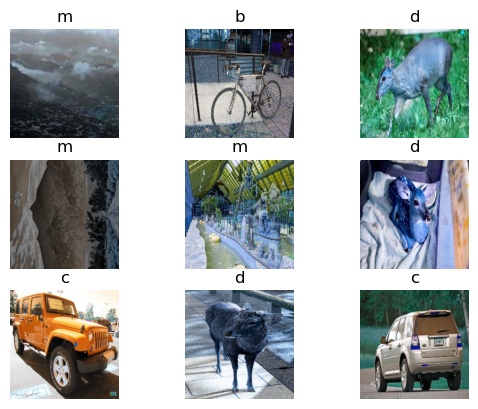

In [3]:
plt.clf()

random_indices = np.random.choice(len(x_train), 9, replace=False)

# Plot the randomly selected images and their labels
for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[idx])
    plt.title(y_train[idx][0])  
    plt.axis("off")

plt.show()

# Prepare the data

In [4]:
# float64 to float32
x_train = x_train.astype("float32") 
x_test = x_test.astype("float32") 

# Model parameters
num_classes = 4
input_shape = x_train.shape[1:]

label_encoder = LabelEncoder()

# Fit the label encoder and transform the labels to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Use the same encoder for consistency

# Convert class vectors to binary class matrices
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

# Build and Train the model

In [8]:
model = models.Sequential([
    layers.Conv2D(12, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.05),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.05),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.15),
    layers.Dense(4, activation='softmax')
])
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10,  verbose=1, restore_best_weights=True )
model.fit(x_train, y_train_categorical, batch_size=64, epochs=100, validation_split=0.15, shuffle=True, callbacks=[early_stopping])

Epoch 1/100
95/95 [==============================] - 126s 1s/step - loss: 0.9934 - accuracy: 0.6315 - val_loss: 0.7168 - val_accuracy: 0.8062
Epoch 2/100
95/95 [==============================] - 119s 1s/step - loss: 0.5680 - accuracy: 0.7906 - val_loss: 0.8066 - val_accuracy: 0.7297
Epoch 3/100
95/95 [==============================] - 119s 1s/step - loss: 0.4170 - accuracy: 0.8504 - val_loss: 0.5200 - val_accuracy: 0.8267
Epoch 4/100
95/95 [==============================] - 131s 1s/step - loss: 0.3228 - accuracy: 0.8825 - val_loss: 0.5201 - val_accuracy: 0.8267
Epoch 5/100
95/95 [==============================] - 151s 2s/step - loss: 0.2045 - accuracy: 0.9327 - val_loss: 0.7118 - val_accuracy: 0.7875
Epoch 6/100
95/95 [==============================] - 145s 2s/step - loss: 0.1337 - accuracy: 0.9585 - val_loss: 0.7994 - val_accuracy: 0.7931
Epoch 7/100
95/95 [==============================] - 142s 1s/step - loss: 0.0882 - accuracy: 0.9742 - val_loss: 1.3918 - val_accuracy: 0.6841
Epoch 

# Evaluate the trained model

In [9]:
score = model.evaluate(x_test, y_test_categorical, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.41190528869628906
Test accuracy: 0.8999999761581421


1/1 [==============================] - 0s 31ms/step
bicycle: 6.21%
cars: 11.73%
deer: 77.50%
mountains: 4.56%


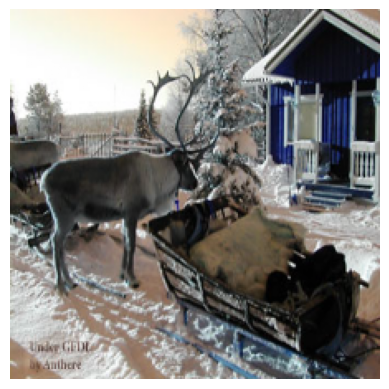

['deer']


In [16]:
index = np.random.randint(0, x_train.shape[0])
image = x_train[index]
prediction = model.predict(np.expand_dims(image, axis=0))
class_labels = ['bicycle', 'cars', 'deer', 'mountains']
prediction_percentages = [value * 100 for value in prediction[0]]

for label, percentage in zip(class_labels, prediction_percentages):
    print(f"{label}: {percentage:.2f}%")

plt.clf()
plt.imshow(image)
plt.axis('off')
plt.show()

predicted_class = np.argmax(prediction, axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)
print(predicted_label)